In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 28 18:10:06 2020
@author: Ajit Johnson Nirmal
Scimap Cell Phenotyping Tutorial
"""

'\nCreated on Fri Jun 28 18:10:06 2020\n@author: Ajit Johnson Nirmal\nScimap Cell Phenotyping Tutorial\n'

In [2]:
# Load necessary libraries
import sys
import os
import anndata as ad
import pandas as pd
import scanpy as sc
import seaborn as sns; sns.set(color_codes=True)

# Import Scimap
import scimap as sm

/opt/anaconda3/envs/scimap/lib/python3.7/site-packages/napari/__init__.py:44: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.6. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [3]:
# Set the working directory
os.chdir ("/Users/aj/Desktop/scimap_tutorial/")

In [4]:
# Load data
adata = ad.read('tutorial_data.h5ad')

In [5]:
# View adata
adata

AnnData object with n_obs × n_vars = 4825 × 30
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'imageid'
    uns: 'all_markers', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Clustering and data exploration

You could use clustering and marker expression analysis within clusters to assign cell types similar to what is carried out with single-cell sequencing data.

In [6]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10) # Computing the neighborhood graph

/opt/anaconda3/envs/scimap/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
sc.tl.umap(adata) # Build a UMAP to visualize the neighbourhood graph

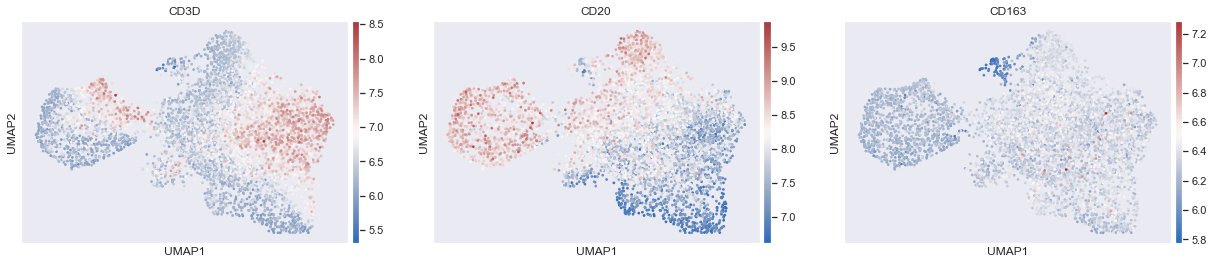

In [8]:
sc.pl.umap(adata, color=['CD3D', 'CD20', 'CD163'], cmap= 'vlag', use_raw=False, s=30) # Plot the UMAP

We can already begin to spot issues with carrying out this mode of phenotyping approach. As you can see there is an area of co-expression of CD3D and CD20, which is likely because of segmentation errors. Additionally the boundaries are not distinct between cell-types and it is highly likely that errors will be introduced due to this reason. 

In [9]:
sc.tl.leiden(adata, resolution = 1) # Clustering the neighborhood graph

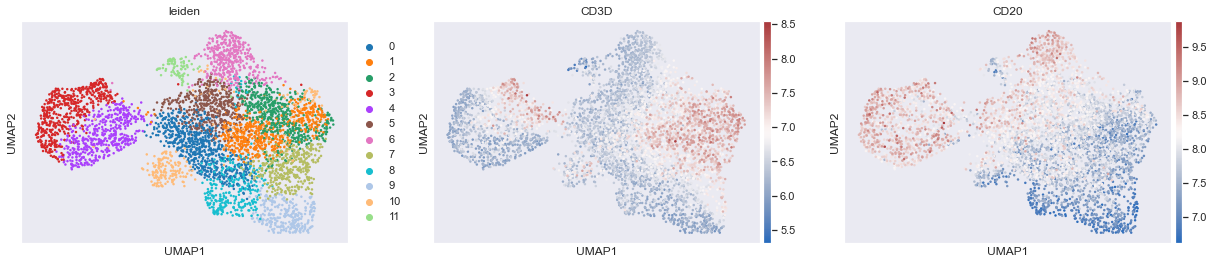

In [10]:
sc.pl.umap(adata, color=['leiden', 'CD3D', 'CD20'],cmap= 'vlag', use_raw=False) # View the clustering

### Finding marker genes for the above clusters

/opt/anaconda3/envs/scimap/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/anaconda3/envs/scimap/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's
/opt/anaconda3/envs/scimap/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


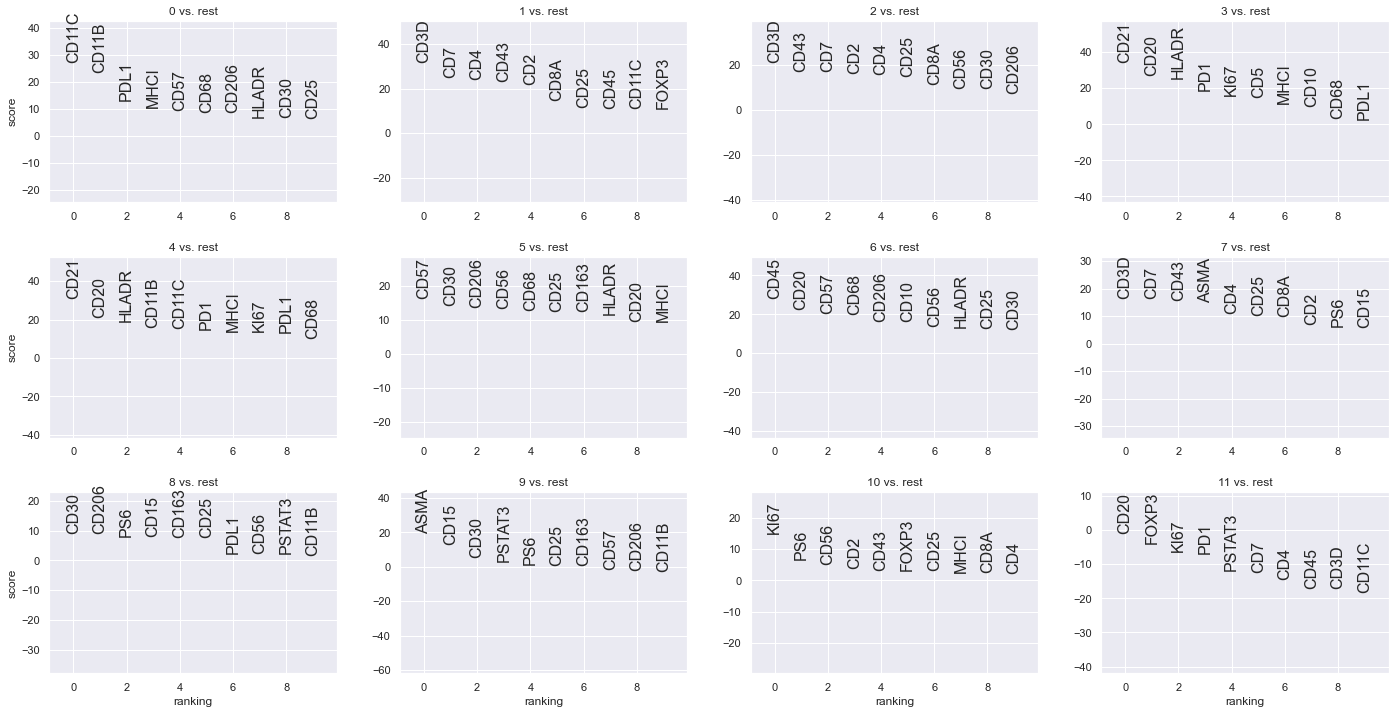

In [11]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False, fontsize=16)

From the above plots, it is likely that clusters 1, 2 and 7 could be combined to form a T cell cluster. However, as mentioned earlier the boundaries are not clear and it only get increasingly complex as one would want to perform deeper phenotyping such as CD4 helper T cells, CD8 T cells, regulatory T cells and so on. 

Additionally, marker analsyis suggests that CD30 is most expressed in cluster 8. If you look at the actual image, you will realize that CD30 is not expressed by any cell in this image and the analysis is picking up high background fluorescence. 

## Probability distribution based phenotyping

This approach is more labor intensive, however is significantly more sensitive and much more scalable than clustering based approaches. Takes less than 5 mins to run over a million cells once the gates are identified.

### In order to run the method, you need 2 things 
- a gating workflow strategy `.csv file`
- manual gates `.csv file`. If manual gates are not provided, the algorithm will attempt to rescale the data by fitting two gaussians on the data. However, it is adviced to perform manual gating as I have found it to be more sensitive.

**The algorithm involves three steps:**
1. Identify the gates using `sm.pl.gate_finder`
2. Rescale the data based on the identified gates using `sm.pp.rescale`
3. Run the phenotyping algorithm on the rescaled data using `sm.tl.phenotype`

### Define manual gates to rescale data before running the phenotyping algorithm
Instantiating the Qt GUI can take a few seconds and if you create the Viewer before it is finished, the kernel will die and the viewer will not launch. For this reason the %gui qt magic command should always be run in a separate cell from creating the viewer

In [15]:
%gui qt

#### Step 1: Identify the gates using `sm.pl.gate_finder`

In [16]:
image_path = '/Users/aj/Desktop/scimap_tutorial/reactive_core.tif'
marker_of_interest = 'CD45'

In [17]:
sm.pl.gate_finder (image_path, adata, marker_of_interest, 
                   from_gate = 5, to_gate = 9, increment = 0.1, 
                   markers=['ASMA','DNA11'], point_size=6)

#### Step 2: Rescale the data based on the identified gates using `sm.pp.rescale`

In [32]:
# Load the manual gates and rescale the data based on the gates
manual_gate = pd.read_csv('manual_gates.csv')
adata = sm.pp.rescale (adata, gate=manual_gate)

Scaling Image [mcmicro_output]
Categories (1, object): [mcmicro_output]
Finding the optimal gate for CD10
Finding the optimal gate for CD2
Finding the optimal gate for CD30
Finding the optimal gate for CD43
Finding the optimal gate for CD5
Finding the optimal gate for CD57
Finding the optimal gate for CD7
Finding the optimal gate for KI67
Finding the optimal gate for MHCI
Finding the optimal gate for PDL1
Finding the optimal gate for PS6
Finding the optimal gate for PSTAT3
Scaling ASMA
Scaling CD163
Scaling CD206
Scaling CD68
Scaling CD20
Scaling CD21
Scaling CD3D
Scaling CD45
Scaling CD56
Scaling CD8A
Scaling FOXP3
Scaling CD11B
Scaling CD11C
Scaling CD15
Scaling CD4
Scaling PD1
Scaling HLADR
Scaling CD25


In [33]:
# View the scaled data (note that the log data is replaced with scaled data)
# If you ever want the log data back you will need to run-  np.log1p(adata.raw.X)
adata.X 

array([[0.17841106, 0.46035427, 0.49203653, ..., 0.15973007, 0.1665647 ,
        0.20024123],
       [0.155838  , 0.21522902, 0.34902406, ..., 0.1522421 , 0.0885678 ,
        0.15338667],
       [0.29090098, 0.37711568, 0.50713067, ..., 0.21580293, 0.17788475,
        0.18778977],
       ...,
       [0.33621626, 0.70411329, 0.70335588, ..., 0.26182348, 0.60810172,
        0.22068843],
       [0.15324935, 0.51454234, 0.60846217, ..., 0.11845023, 0.26558105,
        0.08391592],
       [0.18923565, 0.43441886, 0.57985713, ..., 0.09423545, 0.24047052,
        0.12733514]])

#### Step 3: Run the phenotyping algorithm on the rescaled data using `sm.tl.phenotype`

In [34]:
# Load the gating workflow
phenotype = pd.read_csv('phenotype_workflow.csv')
adata = sm.tl.phenotype_cells (adata, phenotype=phenotype, label="phenotype") 

Phenotyping Other Immune cells
Phenotyping ASMA+ cells
-- Subsetting Other Immune cells
Phenotyping T cells
Phenotyping B cells
Phenotyping Myeloid Lineage
Phenotyping NK cells
Phenotyping Granulocytes
-- Subsetting Myeloid Lineage
Phenotyping T cells
Phenotyping B cells
Phenotyping NK cells
Phenotyping Granulocytes
Phenotyping CD68+ Macrophages
Phenotyping M2 Macrophages
Phenotyping Myeloid Dendritic cells
Phenotyping Follicular Dendritic cells
-- Subsetting T cells
Phenotyping CD4 T cells
Phenotyping CD8 T cells
-- Subsetting CD4 T cells
Phenotyping Regulatory T cells
Phenotyping Follicular Helper T cells
-- Subsetting CD8 T cells
Phenotyping PD1+ T cells
-- Subsetting Myeloid Dendritic cells
Phenotyping CD25+ Dendritic cells
Consolidating the phenotypes across all groups


In [35]:
# Summary of the phenotyping
adata.obs['phenotype'].value_counts()

B cells                       2037
CD4 T cells                    502
ASMA+ cells                    420
Regulatory T cells             418
CD8 T cells                    322
Follicular Helper T cells      282
T cells                        146
Unknown                        140
Other Immune cells             137
Myeloid Dendritic cells        124
Follicular Dendritic cells      87
Myeloid Lineage                 80
PD1+ T cells                    63
M2 Macrophages                  55
Granulocytes                     8
NK cells                         3
CD25+ Dendritic cells            1
Name: phenotype, dtype: int64

It is likely that `CD25+ Dendritic cells, NK cells & Granulocytes` are artifacts. You could set `pheno_threshold_abs= 10` to move these cells into `unknown` category.

**Once the phenotyping is performed, it is adviced to overlay the phenotypes on the image and check if they are correct. If not, alter the `phenotyping workflow` file or the `manual gate` to account for the errors.**

In [31]:
# View phenotypes
sm.pl.image_viewer (image_path, adata, overlay = 'phenotype', point_color='white', point_size=6)

In [25]:
# View Leiden clustering
sm.pl.image_viewer (image_path, adata, overlay = 'leiden', point_color='white', point_size=6)

**This concludes this tutorial**